## Lab 7.2 – Face Recognition : DeepFace, Mediapipe

In this lab, we demonstrate examples of using the DeepFace and MediaPipe frameworks, which are used for face recognition and facial attribute analysis.


## 1) Setup
The code below download dataset, imports all required libraries and defines utility functions that will be used in the rest of this notebook.

In [1]:
# Download library
!pip install deepface
!pip install mediapipe==0.10.13

!wget -O face_landmarker_v2_with_blendshapes.task -q https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task

In [83]:
# Import library
import os
import glob
import tqdm

import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

from deepface import DeepFace
from sklearn.decomposition import PCA

import mediapipe as mp
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

In [4]:
# Download data
!wget https://github.com/pvateekul/digitalhealth-ai2025/raw/main/code/Class07_ASR&FactRecognition/img.zip
!unzip -q -o 'img.zip'

In [85]:
# Load data
images = sorted(glob.glob(os.path.join("/content/img", "*.jpg")))
images

['/content/img/brosnan_01.jpg',
 '/content/img/brosnan_02.jpg',
 '/content/img/brosnan_03.jpg',
 '/content/img/brosnan_04.jpg',
 '/content/img/brosnan_05.jpg',
 '/content/img/prayut_01.jpg',
 '/content/img/prayut_02.jpg',
 '/content/img/prayut_03.jpg',
 '/content/img/prayut_04.jpg',
 '/content/img/prayut_05.jpg',
 '/content/img/trump_01.jpg',
 '/content/img/trump_02.jpg',
 '/content/img/trump_03.jpg',
 '/content/img/trump_04.jpg',
 '/content/img/trump_05.jpg']

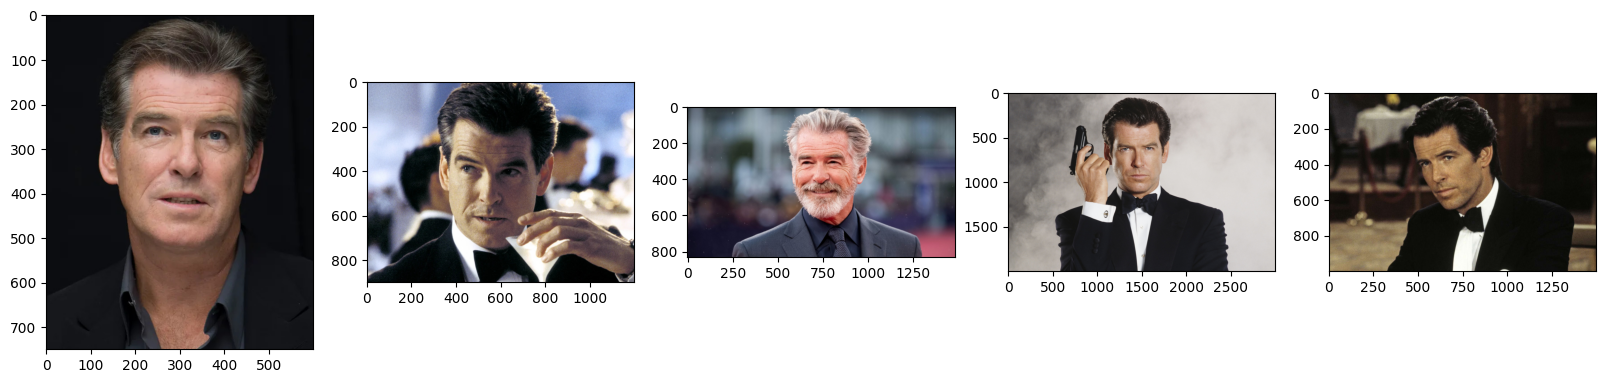

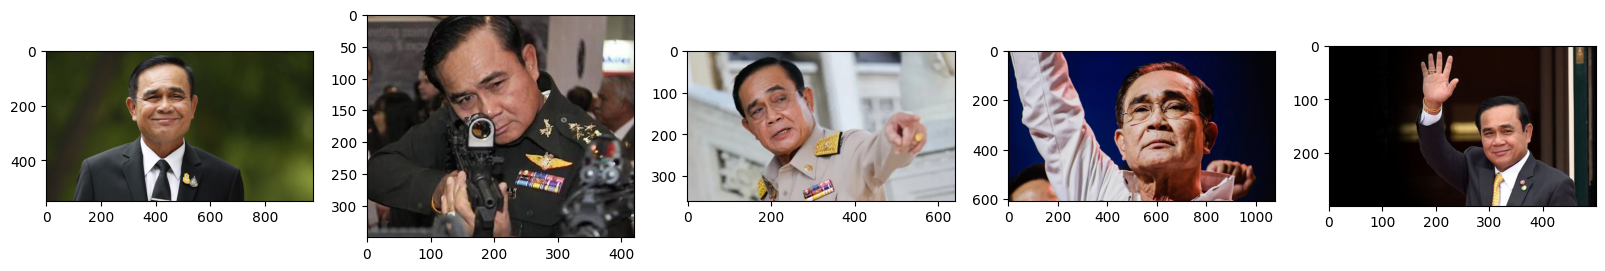

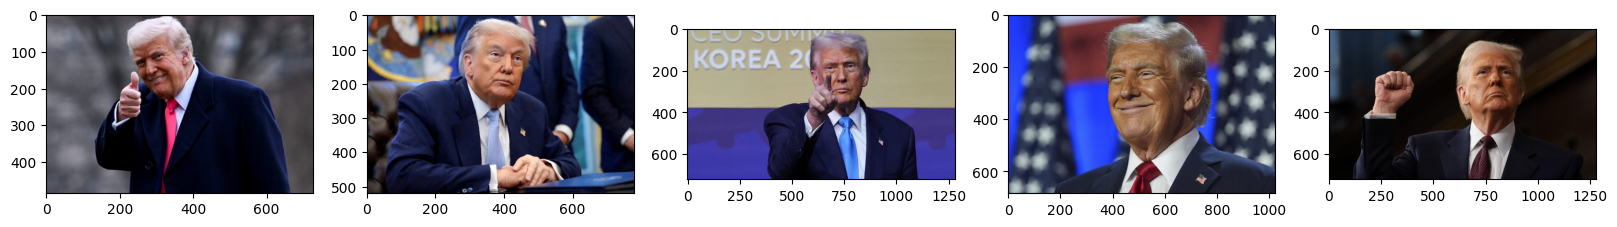

In [87]:
# Example
for i in range(3):
  plt.figure(figsize=(20,20))
  plt.subplot(151)
  plt.imshow(cv2.imread(images[5*i])[...,::-1])
  plt.subplot(152)
  plt.imshow(cv2.imread(images[5*i+1])[...,::-1])
  plt.subplot(153)
  plt.imshow(cv2.imread(images[5*i+2])[...,::-1])
  plt.subplot(154)
  plt.imshow(cv2.imread(images[5*i+3])[...,::-1])
  plt.subplot(155)
  plt.imshow(cv2.imread(images[5*i+4])[...,::-1])

## 2) DeepFace

DeepFace is a lightweight face recognition and facial attribute analysis (age, gender, emotion and race) framework for python. It is a hybrid face recognition framework wrapping state-of-the-art models.

In this lab, we will experiment with three functions of DeepFace:

- Embeddings: `represent` function returns a list of embeddings. Result is going to be the size of faces appearing in the image path.
- Face Verification: `verify` determines whether two facial images belong to the same person or to different individuals
- Facial Attribute Analysis: `analyze` also comes with a facial attribute analysis module including age, gender, facial expression and race predictions.

In [ ]:
database = {
    "brosnan": [
        "/content/img/brosnan_01.jpg",
        "/content/img/brosnan_02.jpg",
        "/content/img/brosnan_03.jpg",
        "/content/img/brosnan_04.jpg",
        "/content/img/brosnan_05.jpg",
    ],
    "prayut": [
        "/content/img/prayut_01.jpg",
        "/content/img/prayut_02.jpg",
        "/content/img/prayut_03.jpg",
        "/content/img/prayut_04.jpg",
        "/content/img/prayut_05.jpg",
    ],
    "trump": [
        "/content/img/trump_01.jpg",
        "/content/img/trump_02.jpg",
        "/content/img/trump_03.jpg",
        "/content/img/trump_04.jpg",
        "/content/img/trump_05.jpg",
    ],
}

In [ ]:
# Embeddings
models = [
    "VGG-Face", "Facenet", "Facenet512", "OpenFace", "DeepFace",
    "DeepID", "ArcFace", "Dlib", "SFace", "GhostFaceNet",
    "Buffalo_L",
]
model_name = models[1]                   # choose model
# store each identity's many embeddings in vector_database dict
vector_database = {}
for identity, images in tqdm.tqdm(database.items()):
    target_embeddings = []
    for image in images:
        emb = DeepFace.represent(
            img_path=image,
            model_name=model_name,                    # choose model
            detector_backend="mtcnn"
        )[0]["embedding"]
        target_embeddings.append(emb)
    vector_database[identity] = target_embeddings

# store all identities' embeddings in single target_identities list
target_identities = []
target_embeddings = []
for identity, embeddings in vector_database.items():
    for embedding in embeddings:
        target_embeddings.append(embedding)
        target_identities.append(identity)

# store corresponding identity for target_identities
image_sources = []
for identity, images in tqdm.tqdm(database.items()):
    for image in images:
        image_sources.append(image.split("/")[-1].split(".")[0])

In [ ]:
# embedding vector
embedding

In [ ]:
# To simplify visualization, we apply PCA to project the features into 2D space
# Where images of the same person in the dataset are clustered closely together.
pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(target_embeddings)
x, y = zip(*vectors_2d)

printed_labels = set()
colors = ['red', 'green', 'blue']

plt.figure(figsize=(8, 6))
for i, (x, y) in enumerate(vectors_2d):
    target_identity = target_identities[i]

    target_idx = None
    for idx, (identity, _) in enumerate(database.items()):
        if target_identity == identity:
            target_idx = idx

    plt.scatter(x, y, color=colors[target_idx])

    # plt.text(x + 0.02, y + 0.02, image_sources[i], fontsize=12, color=colors[target_idx])
    if target_identity not in printed_labels:
        plt.text(x + 0.02, y + 0.02, target_identity, fontsize=12, color=colors[target_idx])
        printed_labels.add(target_identity)

plt.title(f"PCA-reduced 2D representations for {model_name} with indices")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

In [ ]:
# Verify
metrics = ["cosine", "euclidean", "euclidean_l2", "angular"]
result = DeepFace.verify(database["brosnan"][0],database["brosnan"][1], distance_metric = metrics[0] ,model_name = models[0])
result

In [ ]:
# Analyze
obj = DeepFace.analyze(img_path = database["brosnan"][0], actions = ['age', 'gender', 'race', 'emotion'])
obj

## 3) Mediapipe



In [ ]:
def draw_landmarks_on_image(rgb_image, detection_result):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
  # Extract the face blendshapes category names and scores.
  face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
  face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
  # The blendshapes are ordered in decreasing score value.
  face_blendshapes_ranks = range(len(face_blendshapes_names))

  fig, ax = plt.subplots(figsize=(12, 12))
  bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
  ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
  ax.invert_yaxis()

  # Label each bar with values
  for score, patch in zip(face_blendshapes_scores, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

  ax.set_xlabel('Score')
  ax.set_title("Face Blendshapes")
  plt.tight_layout()
  plt.show()

In [ ]:
# Create an FaceLandmarker object.
base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

# Load the input image.
image = mp.Image.create_from_file(database["brosnan"][0])

# Detect face landmarks from the input image.
detection_result = detector.detect(image)

# Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

In [ ]:
# The output includes the positions of facial landmarks along with their corresponding indices, where specific indices represent important facial features,
# such as index 50 corresponding to the left nose sneer (noseSneerLeft).
print(f"n point: {len(detection_result.face_landmarks[0])})")
print(detection_result)

In [ ]:
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

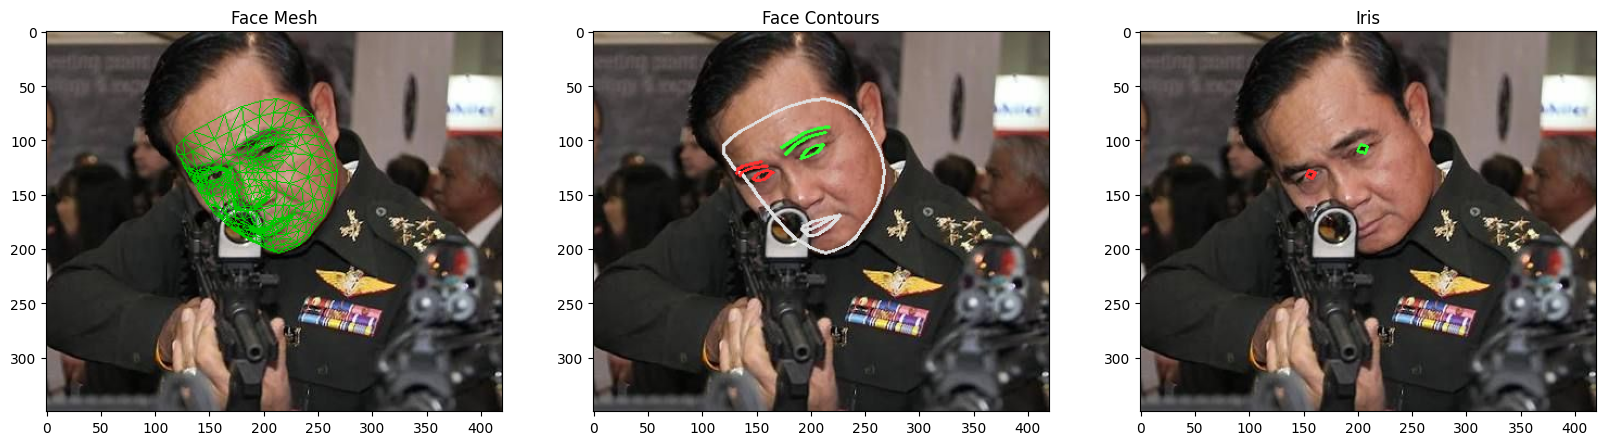

In [79]:
mp_face_mesh = mp.solutions.face_mesh
mp_drawing_styles = mp.solutions.drawing_styles

drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)

face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True,
                                  max_num_faces=1,
                                  refine_landmarks=True,
                                  min_detection_confidence=0.5)


# Convert the BGR image to RGB before processing.
rgb_img = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
results = face_mesh.process(rgb_img)

# Draw face mesh landmarks on the image.
img_mesh = img2.copy()
img_contours = img2.copy()
img_iris = img2.copy()


for face_landmarks in results.multi_face_landmarks:
    # Mesh.
    mp_drawing.draw_landmarks(img_mesh,
                              face_landmarks,
                              mp_face_mesh.FACEMESH_TESSELATION,
                              landmark_drawing_spec=None,
                              connection_drawing_spec=mp_drawing.DrawingSpec(color=(0, 200, 0), thickness=1, circle_radius=1))
    # Contours.
    mp_drawing.draw_landmarks(img_contours,
                              face_landmarks,
                              mp_face_mesh.FACEMESH_CONTOURS,
                              landmark_drawing_spec=None,
                              connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_contours_style())
    # Iris.
    mp_drawing.draw_landmarks(img_iris,
                              face_landmarks,
                              mp_face_mesh.FACEMESH_IRISES,
                              landmark_drawing_spec=None,
                              connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_iris_connections_style())

# Display
plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(img_mesh[...,::-1])
plt.title('Face Mesh');
plt.subplot(132)
plt.imshow(img_contours[...,::-1])
plt.title('Face Contours');
plt.subplot(133)
plt.imshow(img_iris[...,::-1])
plt.title('Iris');